In [ ]:
import gym
import numpy as np
import sys
if "../" not in sys.path:
    sys.path.append("../")
from collections import defaultdict

import itertools
import collections
from typing import Any,List,Sequence,Tuple
import tqdm
# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()


In [ ]:
#@title Environment of Windy grid
import gym
import numpy as np
import sys
from gym.envs.toy_text import discrete

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 10)

        nS = np.prod(self.shape)
        nA = 4

        # Wind strength
        winds = np.zeros(self.shape)
        winds[:,[3,4,5,8]] = 1
        winds[:,[6,7]] = 2

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,7):
                output = " T "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

In [ ]:
env = WindyGridworldEnv()

In [ ]:
print(env.reset())

30


In [ ]:
env.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [ ]:
# Up:0; Right:1; Down:2; Left:3; 
env.step(2)
env.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [ ]:
env.reset()

30

In [ ]:
#policy neural network
#let us initialise parameters in a q matrix of size N_a x N_s
q = np.ones([4,70])
#let us define a function that will return z(s,a) matrices
def z(state,action):
  z_ = np.zeros([70,4])
  z_[state][action] = 1
  return z_

In [ ]:
#let us now define the h function
def h(s_i,a_j):
  z_ = z(s_i,a_j)
  h_ = q[a_j][s_i]*z_[s_i][a_j]
  return h_

In [ ]:
q[3][5] = 1
h(5,3)
np.exp(h(5,3))

2.718281828459045

In [ ]:
#now let us define the policy function
def policy(state):
  sum = 0
  p = []
  for j in range(4):
    sum += np.exp(h(state,j))
  #now probability corresponding to the action
  for j in range(4):
    p_ = np.exp(h(state,j))/sum
    p.append(p_)
  return p

In [ ]:
#code to sample an action from given probability distribution
def sample_action(state):
  prob_action = policy(state)
  action = np.random.choice(np.arange(4),p = prob_action)
  return action

In [ ]:
policy(50)

[0.25, 0.25, 0.25, 0.25]

In [ ]:
sample_action(50)

0

In [ ]:
#convert state into is feature vector
def y(s):
  s_v = np.zeros(70)
  s_v[s] = 1
  return s_v

In [ ]:
#state-value function linear approximation
def v(w,s):
  s_v = y(s)
  return np.dot(w.T,s_v)

#gradient of state-value function
def grad_v(w,s):
  s_v = y(s)
  return s_v

#let us initialise weights of the state-value function
#w = np.random.rand(70)
w = np.ones(70)

In [ ]:
#let us get some expected value
v(w,50)

1.0

In [ ]:
#main part of the code
#initialising step-size vector
alpha = 0.001
alpha_w = alpha*np.ones(np.shape(w))
alpha_q = alpha*np.ones(np.shape(q))

In [ ]:
#defining important parameters
gamma = 1

In [ ]:
#loop forever(for each episode)
def run_episode(q,w):
  #first state will be
  state = env.reset()
  is_done = False 
  I = 1
  #loop while S is not terminal for each time step
  no_step = 0
  total_reward = 0
  while is_done == False:
    #sample an action using the policy
    action = sample_action(state)
    #take the action A, observe S', R
    new_state, reward, is_done, _ = env.step(action)
    if is_done == True:
      delta = reward + gamma*0 -v(w,state)
    else:
      delta = reward + gamma*v(w,new_state) -v(w,state)
    #defining some important parameters
    r_exp = reward + v(w,new_state)
    beta = r_exp - v(w,state)
    #now we will update the weight parameters
    #using adam-algorithm we will write the standard stochastic gradient descent as
    z_times_policy = 0
    prob_action = policy(state)
    for i in range(4):
      z_times_policy += prob_action[i]*z(state,i)
    z_ = z(state,action)
    z_times_policy = z_times_policy.transpose()
    z_ = z_.transpose()
    q += alpha*beta*(z_-z_times_policy)
    w += alpha*beta*y(state)
    no_step += 1
    total_reward += reward
    #print(state,action,reward,no_step)
    state = new_state
  return no_step,total_reward

In [ ]:
#to run an episode but not update its values
def run_episode_dont_update(q,w):
  state = env.reset()
  is_done = False
  #loop while S is not terminal for each time step
  no_step = 0
  total_reward = 0
  while is_done == False:
    action = sample_action(state)
    new_state, reward, is_done, _ = env.step(action)
    no_step += 1
    total_reward += reward
    state = new_state
  return no_step,total_reward

In [ ]:
steps,G = run_episode(q,w)
print(steps,G)

215 -215.0


In [ ]:
#let us find the mean for the model
steps, G = run_episode_dont_update(q,w)
print(steps,G)

368 -368.0


In [ ]:
#let us create a plot to see how the model behaves over 150 episodes
reward_tot = []
no_episodes = []
tot_episodes = 0
N = 150
for i in range(20):
  rew = 0
  for j in range(N):
    steps,rew_temp = run_episode_dont_update(q,w)
    rew += rew_temp
  rew_avg = rew/N
  reward_tot.append(rew_avg)
  no_episodes.append(tot_episodes)
  #now we will train the model for 100 episodes with updates
  for j in range(100):
    a, b = run_episode(q,w)
  tot_episodes += 100

In [ ]:
print(reward_tot)

[-6704.953333333333, -647.36, -267.29333333333335, -233.06, -204.05333333333334, -162.34, -138.18, -121.61333333333333, -113.12666666666667, -111.68, -108.72666666666667, -88.00666666666666, -84.92, -82.28, -81.19333333333333, -72.96, -70.62, -69.10666666666667, -63.32666666666667, -61.906666666666666]


In [ ]:
print(no_episodes)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]


<Figure size 1080x720 with 0 Axes>

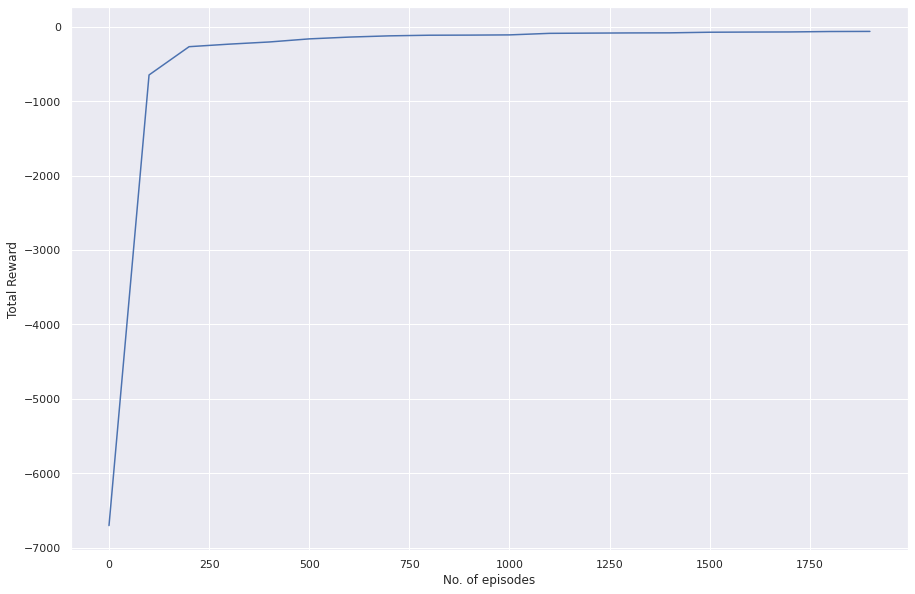

<Figure size 1080x720 with 0 Axes>

In [ ]:
#let us plot the above results
import matplotlib.pyplot as plt
plt.plot(no_episodes,reward_tot)
plt.xlabel("No. of episodes")
plt.ylabel("Total Reward")
plt.figure(figsize=(15,10))


In [ ]:
#now we want to plot all the trajectories to see what the density is like
def state2coord(state):
  a,b = divmod(state,10)
  return a,b

In [ ]:
#we want to write a function that will give a count of each trajectory
times_visited = np.zeros([7,10])
#we will sample 50 trajectories and keep a count of each state visited
no_steps = []
Tot_steps = 0
for t in range(50):
  state = env.reset()
  times_visited[3][0] += 1
  no_steps_this_loop = 0
  is_done = False
  while is_done == False:
    action = sample_action(state)
    new_state, reward, is_done, _ = env.step(action)
    state = new_state
    a,b = divmod(state,10)
    times_visited[a][b] += 1
    no_steps_this_loop +=1
    Tot_steps += 1
  no_steps.append(no_steps_this_loop)

In [ ]:
av_steps = Tot_steps/50
print(av_steps)

67.66


In [ ]:
times_visited

array([[ 40.,  35.,  83.,  73.,  61.,  42.,  39.,  75.,  95.,  96.],
       [ 37.,  39.,  65.,  41.,  53.,  59.,  38.,  19.,   7.,  90.],
       [ 43.,  53.,  73.,  27., 111.,  67.,  35.,   9.,  17.,  87.],
       [101.,  50.,  72.,  44.,  54.,  79.,  15.,  50.,  17.,  78.],
       [ 76.,  50.,  84.,  35.,  62.,  37.,   0.,  10.,  51.,  77.],
       [ 81.,  70., 111.,  87.,  53.,   0.,   0.,   3.,  17.,  36.],
       [ 63.,  64.,  80.,  67.,   0.,   0.,   0.,   0.,  20.,  30.]])

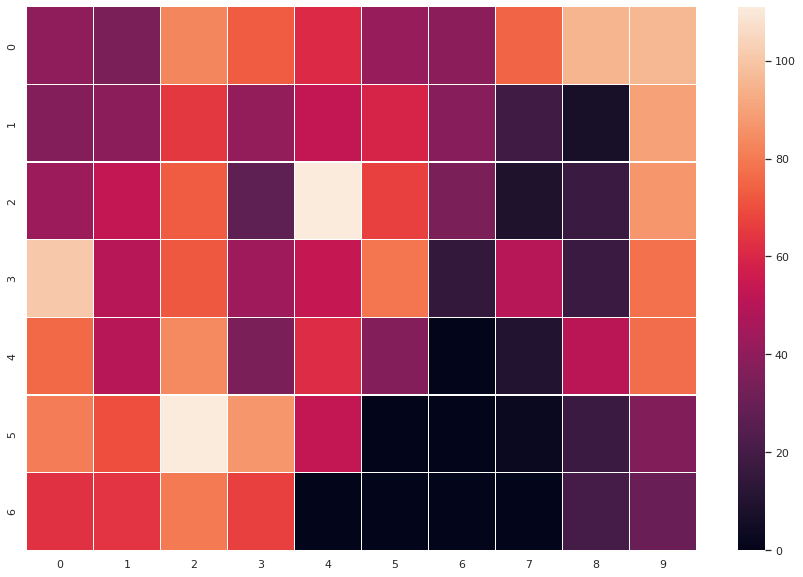

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(times_visited,linewidth = 0.5)